# **Chap 7：自然语言处理**

In [1]:
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import collections
from source.code import ch7
from source.code import utils 
import time

2023-06-13 15:10:24.558634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 15:10:24.888328: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 15:10:24.940629: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-13 15:10:26.698216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **7.3 BERT**

### **7.3.1 BERT模型**

**(1) 从上下文无关到上下文敏感**

在前面介绍的所有的词嵌入预训练模型中，它们都是**上下文无关的词嵌入模型**，给定任何词元 $x$，任何词元的嵌入表示由函数 $f(x)$ 得到，**嵌入函数仅以词元** $x$ **为输入**，例如：
* `we all know that apple is healthy`
* `we all know that apple is a technology company`

同一个单词 `apple` 在不同的上下文语义中表达不同的含义，它们**应当被嵌入到不同的词向量**，而由于之前的词嵌入模型的映射 $f$ 仅以 $x$ 为输入，所以单词 `apple` 会被映射到相同的词向量

因此，另一种词嵌入模型被称为**上下文敏感**，**词的表示嵌入会考虑词元的上下文变量** $c(x)$，将映射改为 $f(x,c(x))$，流行的上下文敏感表示有：
* **TagLM**（language-model-augmented sequence tagger，语言模型增强的序列标记器）
* **CoVe**（Context Vectors，上下文向量）
* **ELMo**（Embeddings from Language Models，语言模型嵌入）

以 ELMo 为例，人们通常将整个文本序列作为输入，**ELMo 使用来自预训练的双向 LSTM**，将序列中的每个词元映射到对应的词向量，然后该向量表示**作为附加的特征添加到下游任务的现有监督模型中**，用于不同的 NLP 任务
* 例如，**将来自 ELMo 的词嵌入向量与现有模型的词元原始表示（例如 GloVe）拼接起来**
* 加入 ELMo 模型时，通常会**冻结 ELMo 的双向 LSTM 中的所有参数**
* **现有的下游监督模型专门为特定的 NLP 任务定制和构造**，例如情感分析、自然语言推断，命名实体识别等

EMLo 这种上下文词向量的加入，在当时改进了很多模型在各 NLP 任务上的表现

**(2) 从特定子任务到通用不可知任务**

EMLo 的加入虽然改善了 NLP 模型的性能，但**每个 NLP 任务都需要依赖于特定设计的模型架构**，为每个 NLP 任务设计一个特定的架构并不是一件容易的事情，并且，**从通用文本语义理解的角度思考，人们也希望获得统一和通用的语言模型**

**GPT**（**Generative Pre-training Transformer**，生成式预训练 Transformer）为上下文的敏感表示设计了通用的**任务无关模型**
* GPT 以 Transformer 的解码器为基础，通过在大量文本上做预训练，以获得词元的上下文敏感词嵌入模型
* 预训练任务为**语言模型**，即**给定上下让模型预测下文**（自监督任务），GPT认为这样的预训练任务能模型获得通用的词元表示能力
* GPT 的**输出向量将被应用到附加的全连接层**，然后与特定的 NLP 预测任务标签计算损失
* 与 ELMo 不同，GPT 在下游有监督学习过程中，不会冻结 Transformer 解码器的参数，Transformer 解码器中的所有参数会**进行微调**，而用于下游任务的全连接网络会从头开始学习

GPT 系列模型的具体细节，我们将在后面的**大语言模型**（**Large Languange Model**，**LLM**）专题中介绍

然而，由于**语言模型 LM**的**自回归特征**，GPT 使用的 **Transformer 解码器每次只能从左到右完成对词元的编码**，即它没法完成**双向编码**，仍然以前面的两个句子为例：
* `we all know that apple is healthy`
* `we all know that apple is a technology company`

对 GPT 的 Transformer 解码器而言，单词 `apple` 被编码时，**都只能看到相同的上文**，因此两个句子中的 `apple` 会得到相同的词嵌入表示，但它们在句子中的含义不同

**(3) BERT**

BERT（**来自 Transformers 的双向编码器表示**）结合了 ELMo 的上下文双向编码优点，和 GPT 的任务无关驱动的优点，它对上下文进行双向编码，并且对于大多数 NLP 任务，只需要最少的架构改变
* 在下游任务的监督学习过程中，BERT 与 GPT 在两个方面相似
  * BERT 将词的表示输入到一个下游输出网络中（例如全连接层），**根据任务性质对模型架构做小改的改动（例如预测是针对每个词，还是针对整个句子）**
  * BERT 与 GPT 一样，需要**对 Transformer 编码器的所有参数做微调**，而额外的输出层将从头开始训练

下图展示了 ELMo，GPT 和 BERT 的对比

<img src="./source/Chap7/BERT对比.svg" width=700>

下面我们具体来介绍 BERT 模型

首先，BERT 的输入文本有**两种格式**：
* **单个文本输入**：此时 BERT 接收一个文本序列 `tokens_a`，并且在其头部和尾部添加上特征词元 `<cls>` 和 `<sep>`，即 `<cls> tokens_a <sep>`
* **文本对输入**：此时 BERT 接收两个文本序列 `tokens_a`，`tokens_b`，并且在头部，中间和尾部添加上特殊词元 `<cls>`，`<sep>`，得到 `<cls> tokens_a <sep> tokens_b <sep>`

我们把以上两种称为**BERT 输入序列**，从而与普通的文本序列区分开来，特殊词元 `<cls>` 被称为**任务词元**，而 `<sep>` 是**分割词元**

为了区分文本对，BERT 根据序列学习得到的**片段编码嵌入** $\mathbf{e}_a,\mathbf{e}_b$ 分别添加到 BERT 文本对的 `tokens_a` 和 `tokens_b` 上，对于单文本输入的情况，则只使用 $\mathbf{e}_a$，函数 `get_BERT_tokens_and_segments` 接收一个句子或两个句子，加工得到 BERT 所需的输入

In [30]:
def get_BERT_tokens_and_segments(tokens_a, tokens_b):
    tokens = ["<cls>"] + tokens_a + ["<sep>"]
    # segments 用于区分两个句子，0 表示第一个句子，1 表示第二个句子
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ["<sep>"]
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

回顾在 Transformer 中，我们对词元的嵌入表示由两部分组成：`Embedding` 嵌入后的向量表示，**加上位置编码**，BERT 稍有不同，它**包含三部分组成**：
* `Embedding` 层的**词嵌入结果**
* 词元在序列中的**位置编码**，与 Transformer 不同的是，**BERT 使用了可学习的位置编码**，实践表明 Transformer 中的**正余弦位置编码**和可学习的位置编码取得的结果没有显著区别
* BERT 还包含**段落嵌入向量**，因为 BERT 序列可能会包含文本对，为了**让模型能够区分出两段不同序列的前后关系**，需要在词元表示中加入段落嵌入向量

<img src="./source/Chap7/bert的输入表示.svg" width=800>

我们类似于 `TransformerEncoder` 来实现一个 `BERTEncoder`，注意 `BERTEncoder` **使用段落嵌入和可学习的位置嵌入**

In [31]:
class BERTEncoder(tf.keras.layers.Layer):
    """
    ### BERTEncdoer
    BERT 编码器
    """
    def __init__(self, vocab_size : int, num_hiddens : int, norm_shape : list, ffn_num_hiddens : int,
                 num_heads : int, num_layers : int, dropout : float, use_bias : bool=True, max_len : int = 1000, 
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super(BERTEncoder, self).__init__(trainable=trainable, name=name, dtype=dtype, dynamic=dynamic, **kwargs)
        # 词元嵌入
        self.token_embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        # 段落嵌入
        self.segment_embedding = tf.keras.layers.Embedding(2, num_hiddens)
        # 生成可学习的位置编码
        self.pos_embedding = tf.Variable(tf.random.normal(shape=(1, max_len, num_hiddens), dtype=tf.float32), trainable=True)
        # 注意力层，沿用 Transformer 的实现
        self.blocks = [
            utils.EncoderBlock(num_hiddens, norm_shape, ffn_num_hiddens, num_heads, dropout, use_bias) for _ in range(num_layers)
        ]
    
    def call(self, tokens, segments, valid_lens, **kwargs):
        # tokens, segments 形状: (batch_size, seq_len)
        # BERT 输入 = 词元嵌入 + 段落嵌入 + 位置嵌入
        X = self.token_embedding(tokens) + self.segment_embedding(segments) + self.pos_embedding[:, :tokens.shape[1], :]
        # 注意力层计算
        for block in self.blocks:
            X = block(X, valid_lens, **kwargs)
        return X

我们来测试 `BERTEncoder` 的接口工作是否正常

In [32]:
vocab_size = 100
encoder = BERTEncoder(
    vocab_size=vocab_size, num_hiddens=256, norm_shape=[2], 
    ffn_num_hiddens=512, num_heads=8, num_layers=2, dropout=0.2)

In [33]:
# 生成词元和段落
tokens = tf.random.uniform((2,8), minval=0, maxval=vocab_size, dtype=tf.int32)
segments = tf.constant([[0, 0, 0, 0, 1, 1, 1, 1], 
                        [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

TensorShape([2, 8, 256])

**(4) BERT 预训练任务**

BERT 包含两个预训练任务：**掩蔽语言模型**（**Masked Language Model**）和**下一句预测**

**任务一：掩蔽语言模型 MLM**

在前面介绍的各种模型中，我们大都是**用左侧的上文来预测接下来的词元**，BERT 为了**充分利用双向编码的上下文表示**，我们**随机掩蔽句子中的词元**，并**使用来自双向上下文的词元表示以自监督的方式预测被掩蔽的词元**，这个任务被称为**掩蔽语言模型**，具体来说，我们随机选择 15% 的词元进行掩蔽作为预测词元
* 要预测一个掩蔽词元，而不造成标签泄漏而作弊，一个简单的方案是**用其他词元替换掉被掩蔽的词元**，例如**使用一个特殊词元** `<mask>`
* 但是，特殊词元 `<mask>` 并**不会出现在真实的微调任务中**，认为引入高达 15% 比例的特殊词元 `<mask>` 会**导致训练集和测试集分布偏差，影响模型的真实表现**
* 一种退而求其次的解决方案是，通过**加入噪声**来让 BERT 学习双向的上下文表示时**不那么偏向于选择掩蔽词元**，具体来说，例如在句子 `this moive is great` 中要掩蔽和预测 `great`，则：
  * 80% 的时间将 `great` 替换为特殊词元 `<mask>`，即 `the movie is <mask>`
  * 10% 的时间将 `great` **替换为随机单词**，即 `the movie is watch`
  * 10% 的时间将 `great` **保持不变**，即保留 `the movie is great`

下面的类 `MaskedLM` 可以预测 BERT 预训练的 MLM 任务中的掩蔽标记，预测时**使用一个带有** `LayerNorm` **层的全连接网络**输出到 `vocab_size`
* 在前向推理中，它**需要两个输入**：`BERTEncoder` 对句子中词元的编码表示，以及用于掩蔽和预测的词元位置，它将输出这些位置的预测结果

In [34]:
class MaskedLM(tf.keras.Model):
    def __init__(self, vocab_size : int, num_hiddens : int, *args, **kwargs):
        super(MaskedLM, self).__init__(*args, **kwargs)
        self.mlp = tf.keras.models.Sequential([
            tf.keras.layers.Dense(num_hiddens, activation='relu'), # 形状: (batch_size, seq_len, num_hiddens)
            tf.keras.layers.LayerNormalization(), # 形状: (batch_size, seq_len, num_hiddens)
            tf.keras.layers.Dense(vocab_size), # 形状: (batch_size, seq_len, vocab_size)
            tf.keras.layers.Softmax() # 得到每个词元的概率分布
        ])
    
    def call(self, X, pred_positions, training=None, mask=None):
        # X 形状: (batch_size, seq_len, num_hiddens)
        # pred_positions 形状: (batch_size, num_pred)
        num_pred = pred_positions.shape[1] # 预测词元的个数
        pred_positions = tf.reshape(pred_positions, shape=(-1,)) # 拉直为向量，形状: (batch_size * num_pred,)
        batch_size = X.shape[0] # 批量大小

        # 假设 batch_size = 2，num_pred = 3，则下面的 batch_idx = [0,0,0,1,1,1]
        batch_idx = tf.range(0, batch_size) # 批量的索引 0,1,2,...，形状: (batch_size,)
        batch_idx = tf.repeat(batch_idx, repeats=num_pred) # 每个批量重复 num_pred 次，形状: (batch_size * num_pred,)

        # 选取需要预测的词元的隐藏状态，形状: (batch_size * num_pred, num_hiddens)
        masked_X = tf.gather_nd(X, indices=tf.stack((batch_idx, pred_positions), axis=1))
        masked_X = tf.reshape(masked_X, shape=(batch_size, num_pred, -1)) # 形状: (batch_size, num_pred, num_hiddens)
        mlm_Y_hat = self.mlp(masked_X,training=training) # 形状: (batch_size, num_pred, vocab_size)
        return mlm_Y_hat

我们可以创建实例，测试 `MaskedLM` 的接口工作是否正常，`MaskedLM` 的**每个预测，结果的大小都等于** `vocab_size`

In [35]:
vocab_size, seq_len, num_hiddens = 100, 20, 256
mlm = MaskedLM(vocab_size, num_hiddens)

# BERT 编码后的输入
encoded_X = tf.random.uniform((2, seq_len, num_hiddens)) # 形状: (batch_size, seq_len, num_hiddens)
# 指定需要预测的词元的位置
pred_positions = tf.constant([[1, 5, 2], 
                              [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, pred_positions)
mlm_Y_hat.shape # (batch_size, num_pred, vocab_size)

TensorShape([2, 3, 100])

MLM 也将使用**交叉熵损失函数来指导模型进行训练**

In [36]:
# 假设 mlm_Y 是真实标签
mlm_Y = tf.constant([[7, 8, 9],
                     [2, 3, 4]])
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
loss_func(y_true=mlm_Y, y_pred=mlm_Y_hat).shape # (batch_size, num_pred)

TensorShape([2, 3])

**任务二：下一句预测**

MLM 有助于帮助 BERT 获得结合上下文的单词编码能力，但是**这个任务无法建模文本之间的逻辑关系**，为了帮助 BERT 理解两个文本序列之间的关系，**BERT 在预训练中考虑了下一句预测的二分类任务**，在为预训练生成句子对时，有一半的时间它们确实是连续的两句话（即**正类样本**），在另一半时间，第二个句子是从语料库随机抽取的（即**负类样本**）

`NextSentencePred` 类使用一个全连接神经网络构造二元分类器，来**预测第二个句子是否是 BERT 输入序列的第一个句子的下一句话**
* 由于 `Transformer` 编码器中使用**自注意力**，所以**特殊词元** `<cls>` **的 BERT 表示可以视为对输入的两个句子进行了编码**，因此，分类器将 `<cls>` 的 BERT 表示作为输入

In [37]:
class NextSentencePred(tf.keras.Model):
    def __init__(self, num_hiddens : int, *args, **kwargs):
        super(NextSentencePred, self).__init__(*args, **kwargs)
        self.classifier = tf.keras.models.Sequential([
            tf.keras.layers.Dense(num_hiddens, activation='tanh'),
            tf.keras.layers.Dense(2), # 二分类
            tf.keras.layers.Softmax()
        ])
    
    def call(self, cls):
        # BERT 的 cls 表示，形状: (batch_size, num_hiddens)
        return self.classifier(cls)

我们可以创建实例，测试 `NextSentencePred` 的接口是否工作正常

In [38]:
batch_size, seq_len, num_hiddens = 4, 20, 256
encoded_X = tf.random.uniform((batch_size, seq_len, num_hiddens))
nsp = NextSentencePred(num_hiddens=num_hiddens) # 实例化 NextSentencePred 类

# cls 放在文本序列的开头
cls = encoded_X[:, 0, :] # 形状: (batch_size, num_hiddens)
nsp_Y_hat = nsp(cls)
nsp_Y_hat.shape # (batch_size, 2)

TensorShape([4, 2])

下一句预测任务**依然使用交叉熵损失函数**

In [39]:
# 假设 mlm_Y 是真实标签
nsp_Y = tf.constant([0, 1, 1, 0])
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
loss_func(y_true=nsp_Y, y_pred=nsp_Y_hat).shape # (batch_size, )

TensorShape([4])

最后我们再次强调，**BERT 的预训练任务所需要的标签都可以从预训练语料库中生成，无需人工标注**，因此这是一个**自监督任务**
* 这也是目前大型神经网络模型的发展方向，即尽可能减少模型对人工标注数据集的依赖
* 原始的 BERT 在图书语料库和英文维基百科上进行了预训练，这是两个非常庞大的数据集，分别包含 8 亿个单词和 25 亿个单词

最后我们将上面两个预训练任务代码整合，包装为 `BERTModel`，**最终的损失函数是 MLM 任务和下一句预测任务的损失函数的线性组合**

In [40]:
class BERTModel(tf.keras.Model):
    def __init__(self, vocab_size : int, num_hiddens : int, norm_shape : list, ffn_num_hiddens : int,
                 num_heads : int, num_layers : int, dropout : float, max_len : int=1000, *args, **kwargs):
        super(BERTModel, self).__init__(*args, **kwargs)
        # 创建 BERT 编码器
        self.encoder = ch7.BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_hiddens, 
                                       num_heads, num_layers, dropout, max_len=max_len)
        # 两个预训练任务
        self.mlm = MaskedLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred(num_hiddens)
    
    def call(self, tokens, segments, valid_lens=None, pred_positions=None, training=None):
        encoded_X = self.encoder(tokens, segments, valid_lens, training=training)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions, training=training)
        else:
            mlm_Y_hat = None
        nsp_Y_hat = self.nsp(encoded_X[:, 0, :]) # cls = encoded_X[:, 0, :]
        return encoded_X, mlm_Y_hat, nsp_Y_hat

### **7.3.2 BERT预训练数据集**

我们演示通过一个较小的数据集 `WikiText-2` 来**构造 MLM 和下一句预测所需的数据集**
* `WikiText-2` 每行代表一个段落，任意标点符号的前面都添加了空格符
* 我们**保留至少有两句话的段落**
* 我们简单起见，我们仅**用句号** `" . "` **作为分隔符来拆分句子**，还有一些更复杂的拆分策略，我们在习题中讨论

In [43]:
def read_wikitext(path : str):
    import random
    with open(path, 'r') as f:
        lines = f.readlines()
    # 用句号 . 作为分隔符，然后过滤掉长度小于 2 的序列
    # 段落 paragraphs 的每个元素是包含大于两个句子的列表
    paragraphs = [line.strip().lower().split(' . ') for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [65]:
path = "./source/data/text/wikitext-2/wiki.train.tokens"
paragraphs = read_wikitext(path)
paragraphs = [utils.english_tokenize(paragraph) for paragraph in paragraphs] # 分词
print("段落数量:", len(paragraphs))
print("第一段句子数量:", len(paragraphs[0]))

段落数量: 15496
第一段句子数量: 5


**(1) 下一句预测的数据**

函数 `get_next_sentence` 接收 `sentence`，`next_sentence` 和 `paragraphs`
* 50% 的几率，函数返回 `sentence` 和 `next_sentence`，保留句子的连续关系
* 50% 的几率，将从 `paragraphs` 中随机挑选一个句子替换掉 `next_sentence`

In [66]:
def get_next_sentence(sentence, next_sentence, paragraphs):
    import random
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs 是一个二维列表，每个元素是包含多个句子的段落
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

通过调用 `get_next_sentence` ，函数 `get_nsp_data_from_paragraph` 生成下一句预测任务的数据集

In [67]:
def get_nsp_data_from_paragraph(paragraph, paragraphs, max_len):
    # paragraph 是一个段落的句子列表，每个句子是词元列表
    # paragraphs 是包含多个段落的列表
    nsp_data = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = get_next_sentence(paragraph[i], paragraph[i + 1], paragraphs)
        # 用 <cls> 和 <sep> 拼接句子
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = get_BERT_tokens_and_segments(tokens_a, tokens_b)
        nsp_data.append((tokens, segments, is_next))
    return nsp_data

In [77]:
nsp_data = get_nsp_data_from_paragraph(paragraphs[0], paragraphs, max_len=64)
print("句子数量:", len(nsp_data))
[data[2] for data in nsp_data]

句子数量: 4


[False, False, True, True]

**(2) 掩蔽语言模型的数据**

函数 `get_replace_mlm_tokens` 用于对词元列表 `tokens` 中的单词进行随机替换
* `valid_pred_positions` 是**不包含特殊词元**的 BERT 输入序列的词元索引列表，BERT 中我们不能掩蔽特殊词元 `<cls>, <sep>`，掩蔽和预测它们没有意义
* `num_mlm_preds` 是要掩蔽预测的词元数量（15% 的词元被掩蔽并预测）

In [96]:
def get_replace_mlm_tokens(tokens, valid_pred_positions, num_mlm_preds, vocab):
    import random
    # 创建 MLM 的输入和标签
    mlm_input = [token for token in tokens]
    pred_positions_and_labels = []

    # 打乱 valid_pred_positions 中的元素顺序
    random.shuffle(valid_pred_positions)
    for mlm_pred_position in valid_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% 的时间，将 token 替换成 <mask>
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% 的时间，将 token 替换成一个随机词元
            if random.random() < 0.5:
                masked_token = random.choice(vocab.idx_to_token)
            # 10% 的时间，保持 token 不变
            else:
                masked_token = tokens[mlm_pred_position]
        # 完成替换
        mlm_input[mlm_pred_position] = masked_token
        # 记录下被替换的词元位置，及其被替换前的词元，作为标签
        pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input, pred_positions_and_labels

函数 `get_mlm_data_from_tokens` 通过调用 `get_replace_mlm_tokens` 将 BERT 输入序列作为输入，然后**返回三个元素**：
* 被掩蔽替换后输入序列的词元索引 `vocab[mlm_input]`
* 要预测的词元的位置 `pred_positions`
* 要预测的词元的标签词元索引 `vocab[mlm_pred_labels]`

In [97]:
def get_mlm_data_from_tokens(tokens, vocab):
    valid_pred_positions = [] # 初始化可以被掩蔽词元的位置列表
    for i,token in enumerate(tokens):
        # 排除掉特殊词元
        if token in ['<cls>', '<sep>']:
            continue
        valid_pred_positions.append(i)
    
    # 选择 15% 的词元进行掩蔽
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input, pred_positions_and_labels = get_replace_mlm_tokens(tokens, valid_pred_positions, num_mlm_preds, vocab)
    # 根据被掩蔽词元的位置进行排序
    pred_positions_and_labels = sorted(pred_positions_and_labels, key=lambda x: x[0])
    # 分别取出被掩蔽词元的位置和标签
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]

    return vocab[mlm_input], pred_positions, vocab[mlm_pred_labels]

In [98]:
sentence = [sent for paragraph in paragraphs for sent in paragraph]
vocab = utils.Vocab(sentence, min_freq=5)
# 添加三个特殊词元 <cls>, <sep>, <mask>
special_tokens = ['<mask>', '<cls>', '<sep>']
for token in special_tokens:
    vocab.idx_to_token.append(token)
    vocab.token_to_idx[token] = len(vocab.idx_to_token) - 1

In [110]:
mlm_input, pred_pos, mlm_labels = get_mlm_data_from_tokens(tokens=nsp_data[0][0], vocab=vocab)
print("mlm_input masked:", tf.gather(mlm_input, pred_pos).numpy().tolist())
print("masked words:", tf.gather(vocab.idx_to_token, mlm_labels).numpy().tolist())

mlm_input masked: [20255, 20255, 2564, 20255, 20255, 20255, 20255, 20255]
masked words: [b'(', b'commonly', b'b', b'on', b'1996', b'county', b'of', b'of']


**(3) 合并两个任务的数据**

为了将两个任务的数据合并，我们还需要定义一个辅助函数 `pad_BERT_inputs`，通过填充，我们可以**将所有的句子处理到相同的长度，从而将不同的句子组装为批量数据**

In [1]:
def pad_BERT_inputs(examples, max_len, vocab):
    # examples 是一个列表，其中的每个元素都包含 5 个元素
    # 由函数 get_nsp_data_from_paragraph 和 get_mlm_data_from_tokens 生成
    # 分别是：序列词元索引、被掩蔽词元的位置、被掩蔽词元的标签索引、段落标记、下一句预测标签
    max_num_mlm_preds = round(max_len * 0.15) # 最多被掩蔽词元的数量
    # 初始化 BERT 所需要的各个输入和标签
    all_token_ids, all_segments, valid_lens  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    
    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        # 在末尾添加 <pad> 符号，填充句子到 max_len 长度
        all_token_ids.append(tf.constant(token_ids + [vocab['<pad>']] * (max_len - len(token_ids)), dtype=tf.int32))
        all_segments.append(tf.constant(segments + [1] * (max_len - len(segments)), dtype=tf.int32))
        # valid_lens 统计除去 <pad> 之外的有效词元的长度
        valid_lens.append(tf.constant(len(token_ids), dtype=tf.float32))

        # 预测位置填充到 max_num_mlm_preds 长度
        all_pred_positions.append(tf.constant(pred_positions + [0] * (max_num_mlm_preds - len(pred_positions)), dtype=tf.int32))
        # weights 和 valid_lens 作用类似，MLM 任务中填充词乘以 weights 从而过滤损失
        all_mlm_weights.append(tf.constant([1.0] * len(mlm_pred_label_ids) + 
                                           [0.0] * (max_num_mlm_preds - len(pred_positions)), dtype=tf.float32))
        all_mlm_labels.append(tf.constant(mlm_pred_label_ids + [vocab["<pad>"]] * (max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=tf.int32))
        # is_next 作为 NSP 的标签
        nsp_labels.append(tf.constant(is_next, dtype=tf.int32))
    
    return (all_token_ids, all_segments, valid_lens, 
            all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels)

`WikiTextDataset` 类在初始化函数 `__init__` 中准备好 `pad_BERT_inputs` 所需要的 `examples`，然后保存 BERT 所需的所有数据

In [22]:
class WikiTextDataset:
    def __init__(self, path : str, max_len : int=100, batch_size : int=32) -> None:
        self.max_len = max_len
        self.batch_size = batch_size
        paragraphs = read_wikitext(path) # 读取数据集
        # 进行分词，按单词进行分词
        paragraphs = [utils.english_tokenize(paragraph,token="word") for paragraph in paragraphs]
        # 将段落拆分为句子
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]

        # 创建词表
        self.vocab = utils.Vocab(sentences, min_freq=5)
        # 为词表加入三个特殊词元
        special_tokens = ['<mask>', '<cls>', '<sep>']
        for token in special_tokens:
            self.vocab.idx_to_token.append(token)
            self.vocab.token_to_idx[token] = len(self.vocab.idx_to_token) - 1
        
        # 获得 NSP 任务的数据
        examples = []
        for paragraph in paragraphs:
            examples.extend(get_nsp_data_from_paragraph(paragraph, paragraphs, max_len))
        # 获得 MLM 任务的数据
        examples = [(get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next)) for tokens, segments, is_next in examples]

        # 填充数据
        (self.all_token_ids, self.all_segments, self.valid_lens, 
         self.all_pred_positions, self.all_mlm_weights, 
         self.all_mlm_labels, self.nsp_labels) = pad_BERT_inputs(examples, max_len, self.vocab)
    
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx], self.valid_lens[idx],
                self.all_pred_positions[idx], self.all_mlm_weights[idx],
                self.all_mlm_labels[idx], self.nsp_labels[idx])
    
    def __len__(self):
        return len(self.all_token_ids)

    def create_dataset(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.all_token_ids, self.all_segments, self.valid_lens,
                                                      self.all_pred_positions, self.all_mlm_weights,
                                                      self.all_mlm_labels, self.nsp_labels))
        dataset = dataset.shuffle(len(self.all_token_ids)).batch(self.batch_size)
        return dataset

接下来我们创建数据集实例，加载批量数据，检查函数接口工作是否正常

In [13]:
path = "./source/data/text/wikitext-2/wiki.train.tokens"
wikitext = WikiTextDataset(path=path, max_len=64, batch_size=32)
train_iter = wikitext.create_dataset()

In [14]:
for (tokens_X, segments_X, valid_lens_X, pred_positions_X, mlm_weights_X, mlm_Y, nsp_Y) in train_iter:
    print(tokens_X.shape) # (batch_size, max_len)
    print(segments_X.shape) # (batch_size, max_len)
    print(valid_lens_X.shape) # (batch_size,)
    print(pred_positions_X.shape) # (batch_size, max_num_mlm_preds)
    print(mlm_weights_X.shape) # (batch_size, max_num_mlm_preds)
    print(mlm_Y.shape) # (batch_size, max_num_mlm_preds)
    print(nsp_Y.shape) # (batch_size,)
    break

(32, 64)
(32, 64)
(32,)
(32, 10)
(32, 10)
(32, 10)
(32,)


最后，我们可以检查词表大小，在**过滤了频次小于 5 的单词后，词表大小依然达到了两万**

In [15]:
print("词表大小：", len(wikitext.vocab))

词表大小： 20258


### **7.3.3 BERT预训练**

原始 BERT 共实现了两个版本：
* 基础版：$\text{BERT}_\text{BASE}$，`num_layers = 12, num_hiddens = 768, num_heads = 12`，参数量 1.1 亿
* 加强版：$\text{BERT}_\text{LARGE}$，`num_layers = 24, num_hiddens = 1024, num_heads = 16`，参数量 3.4 亿

以上两个 BERT 模型对于演示都太大了，训练速度很慢，我们创建一个非常小的 BERT，指定 `num_layers = 2, num_hiddens = 256, num_heads = 4`

In [3]:
path = "./source/data/text/wikitext-2/wiki.train.tokens"
wikitext = ch7.WikiTextDataset(path=path, max_len=64, batch_size=512)
train_iter = wikitext.create_dataset()
vocab = wikitext.vocab

2023-06-13 15:10:46.842556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 15:10:48.433562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30000 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


In [4]:
bert = ch7.BERTModel(vocab_size=len(vocab),num_hiddens=256,num_layers=2,num_heads=4,
                     ffn_num_hiddens=128,norm_shape=[2],dropout=0.2)

我们定义一个函数 `get_BERT_pretrain_loss` 来计算 BERT 预训练时候的损失

In [5]:
def get_BERT_pretrain_loss(model, vocab_size, tokens_X, segments_X, valid_lens_X, pred_positions_X, mlm_weights_X, mlm_Y, nsp_Y):
    # 前向计算
    _, mlm_Y_hat, nsp_Y_hat = model(tokens_X, segments_X, valid_lens_X, pred_positions_X, training=True)
    
    # 计算 MLM 损失
    unweighted_mlm_l = tf.keras.losses.sparse_categorical_crossentropy(y_true=mlm_Y, y_pred=mlm_Y_hat)
    mlm_l = unweighted_mlm_l * mlm_weights_X # 形状: (batch_size, max_num_mlm_preds)
    mlm_l = tf.reduce_sum(mlm_l) / (tf.reduce_sum(mlm_weights_X) + 1e-8) # 做数值保护

    # 计算 NSP 损失
    nsp_l = tf.keras.losses.sparse_categorical_crossentropy(y_true=nsp_Y, y_pred=nsp_Y_hat)
    nsp_l = tf.reduce_mean(nsp_l)
    # 总体损失
    loss = mlm_l + nsp_l

    return mlm_l, nsp_l, loss

定义训练函数 `pretrain_BERT`
* 与以往的训练逻辑不同，我们这里**直接控制模型梯度下降更新的迭代次数** `total_steps`，而不使用 `Epochs`

In [7]:
def pretrain_BERT(model, train_iter, vocab, total_steps : int=50, lr : float=0.01):
    # 定义优化器
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    # 展示训练进度
    animator = utils.Animator(xlabel='epoch', ylabel="loss", xlim=[1, total_steps], legend=['mlm_loss', 'nsp_loss'])

    step = 0
    batch_mlm_loss = tf.constant(0.0)
    batch_nsp_loss = tf.constant(0.0)
    num_batches = tf.constant(0.0)
    num_tokens = 0
    total_time = 0

    while step < total_steps:
        for (tokens_X, segments_X, valid_lens_X, pred_positions_X, mlm_weights_X, mlm_Y, nsp_Y) in train_iter:
            start = time.time()
            with tf.GradientTape() as tape:
                mlm_l, nsp_l, loss = get_BERT_pretrain_loss(model, len(vocab), tokens_X, segments_X, valid_lens_X, 
                                                            pred_positions_X, mlm_weights_X, mlm_Y, nsp_Y)
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            optimizer.apply_gradients(zip(grads, weights))

            batch_mlm_loss += mlm_l
            batch_nsp_loss += nsp_l
            num_batches += 1.0
            num_tokens += tokens_X.shape[0]
            end = time.time()
            total_time += end - start

            animator.add(step+1, ((batch_mlm_loss/num_batches).numpy(), (batch_nsp_loss/num_batches).numpy()))
            step += 1
            if step == total_steps:
                break
    print(f"{num_tokens / total_time:.2f} 句子对 / 每秒")
    return model

1821.41 句子对 / 每秒


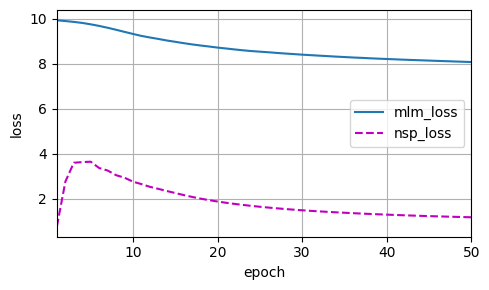

In [8]:
bert = pretrain_BERT(bert, train_iter, vocab, total_steps=50, lr=0.1)

In [29]:
# 保存模型
# bert.save_weights("./source/model/ch7_bert_pretrain.h5")

最后，我们尝试**利用预训练好的 BERT 模型来做词嵌入，将词元、句子表示为向量**

In [9]:
def get_BERT_encoding(model, vocab, tokens_a, tokens_b=None):
    # 将 tokens_a 和 tokens_b 变换为 BERT 序列
    tokens, segments = ch7.get_BERT_tokens_and_segments(tokens_a, tokens_b)
    
    # 获得词元索引，并添加 batch_size 维度
    tokens_ids = tf.constant(vocab[tokens], dtype=tf.int32)[None, :]
    segments = tf.constant(segments, dtype=tf.int32)[None, :]
    valid_len = tf.constant([len(tokens)], dtype=tf.int32)

    # 获得 BERT 编码器的输出
    encoded_X, _, _ = model(tokens_ids, segments, valid_len)
    return encoded_X

我们下面来尝试对一段话进行编码：`what is apple ?`

In [21]:
tokens_a = ['what', 'is', 'apple', '?']
# 添加上 <cls> 和 <sep> 词元
# 变为 ['<cls>', 'what', 'is', 'apple', '?', '<sep>']
encoded_text = get_BERT_encoding(bert, vocab, tokens_a)
encoded_cls = encoded_text[:, 0, :]
encoded_text_apple = encoded_text[:, 3, :]
print("编码后句子的形状：", encoded_text.shape)
print("编码后句子的整体表示 <cls> 的形状：", encoded_cls.shape)
print("编码后，词元 apple 的向量表示：\n", encoded_text_apple[0, :3])

编码后句子的形状： (1, 6, 256)
编码后句子的整体表示 <cls> 的形状： (1, 256)
编码后，词元 apple 的向量表示：
 tf.Tensor([ 0.95089483 -0.8938876   1.120297  ], shape=(3,), dtype=float32)


我们接下来为这句话**添加下文** `tokens_b`，观察词元 `apple` 的**编码结果的变化**

In [22]:
tokens_a = ['what', 'is', 'apple', '?']
tokens_b = ['one', 'of', 'my', 'favorite', 'fruits']
# 添加上 <cls> 和 <sep> 词元
# 变为 ['<cls>', 'what', 'is', 'apple', '?', '<sep>', 'one', 'of', 'my', 'favorite', 'fruits', '<sep>']
encoded_text = get_BERT_encoding(bert, vocab, tokens_a, tokens_b)
encoded_cls = encoded_text[:, 0, :]
encoded_text_apple = encoded_text[:, 3, :]
print("编码后句子的形状：", encoded_text.shape)
print("编码后句子的整体表示 <cls> 的形状：", encoded_cls.shape)
print("编码后，词元 apple 的向量表示：\n", encoded_text_apple[0, :3])

编码后句子的形状： (1, 12, 256)
编码后句子的整体表示 <cls> 的形状： (1, 256)
编码后，词元 apple 的向量表示：
 tf.Tensor([ 1.2560798  -1.0285051   0.98350006], shape=(3,), dtype=float32)


现在，我们可以观察到
* **同一个词元在不同的上下文语境中，将会得到不同的词元向量编码表示**
* 这验证了 **BERT 是上下文敏感的词元编码器**
* 上下文敏感的词元编码能够更加正确地表示词元在语境中的含义

----

### **练习**

----